# AIDAR Objective 1.0 Hypotheses Testing

We are leaning towards employing [Naive Bayes](https://kiranvoleti.com/how-to-use-a-naive-bayes-classifier-for-marketing-analytics) or similar classifier for our budget predictions (i.e. autoML with [PyCaret](https://medium.com/@atalarifqy/optimizing-machine-learning-workflows-with-pycaret-e0b19d8caf2c)). In order to confirm the associated and impacting features on the actions, we must first run a Chi-square test to validate the importance of the variables.

* Query a representative sample of the relevant dataset for each hypotheses
* Test the null and alternative hypotheses (P-value) for the confidence interval 
* Present the results for discussion and evaluation

[Fundermentals of Chi-Square Test](https://www.simplilearn.com/tutorials/statistics-tutorial/chi-square-test)

In [1]:
'''
    WARNING CONTROL to display or ignore all warnings
'''
import warnings; warnings.simplefilter('ignore')     #switch betweeb 'default' and 'ignore'
import traceback

''' Set debug flag to view extended error messages; else set it to False to turn off debugging mode '''
debug = True


| Analytics Activity |Hypothese to test | Required data |
|--------|-----|--------------|
|AA-1.1.1.1 |Test whether Adsets with higher budget_remaining correlate with higher impressions but not necessarily with better ROI. |client type<br>ad_id<br>timestamp<br>remaining budget (allocated - spent)<br>impressions count<br>ROI (CTR, CPM, ...) |
|AA-1.1.1.2 |Discover all  other correlating factors that may contribute to underperforming adsets | |
|AA-1.2.1.1 |Consider all optimization_goal types (e.g., conversions) and their Powerset combinations on Adsets that outperform those targeting general engagement. | |
|AA-1.3.1.1 |Campaigns with defined bid_strategy types (e.g., cost cap) lead to lower CPA. | |
|AA-1.3.1.2 |Look at the statistically significant power sets of objective and strategy elements | |
|AA-1.4.1.1 |Test whether campaigns with a higher daily_budget allocated to peak hours achieve better ROI | |
|AA-1.4.1.2 |Calculate the timeframes that offer high impact time segments or seasonal effects (e.g. peak hours) | |
|AA-1.5.1.1 |Evaluate whether Ads targeting specific demographics yield better ROI than generic targeting. | |

## Instantiate Classes

In [2]:
import os
import sys
import numpy as np
from pyspark.sql import functions as F
# import tensorflow_probability as tfp
# import tensorflow as tf

proj_dir = os.path.abspath(os.pardir)
sys.path.insert(1,proj_dir.split('mining/')[0])
# from rezaware.modules.etl.loader import sparkRDBM as db
# from rezaware.modules.etl.loader import sparkFile as file
from mining.modules.budget.optimization import rwAdsDataFile as file

''' restart initiate classes '''
if debug:
    import importlib
    # db = importlib.reload(db)
    file=importlib.reload(file)
    # attr=importlib.reload(attr)

__desc__ = "read and write dataset for MCMC sampling"

clsFile = file.dataWorkLoads(
    desc = "optimizing action_type budgets for an ad",
    f_store_mode='local-fs',
    f_store_root=proj_dir.split('mining/')[0],
    jar_dir=None,
)
# if clsSDB.session:
#     clsSDB._session.stop
print("\n%s class initialization and load complete!" % __desc__)

All functional __PROPATTR__-libraries in OPTIMIZATION-package of BUDGET-module imported successfully!
All functional RWADSDATA-libraries in OPTIMIZATION-package of BUDGET-module imported successfully!
All functional RWADSDATA-libraries in OPTIMIZATION-package of BUDGET-module imported successfully!
All functional APP-libraries in REZAWARE-package of REZAWARE-module imported successfully!
__propAttr__ Class initialization complete
All functional __PROPATTR__-libraries in LOADER-package of ETL-module imported successfully!
All functional SPARKFILE-libraries in LOADER-package of ETL-module imported successfully!
__propAttr__ Class initialization complete
sparkFile Class initialization complete
rwAdsData Class initialization complete

read and write dataset for MCMC sampling class initialization and load complete!


## Load data
There are two options for loading the data
1. querying with a select statement by defining the sql _query_ statement string
2. reading an entire table with row limit by defining the _tbl_ comprising _project:dataset.table_

By default the function _read_data_from_table() will check for the select variable; else will revert to the _tbl description to read the data
Use either or; i.e.,: 
* if using the select query set ```db_table = None``` and assign ```select=query```
* if using db_table, then set ```select = None``` and assign ```db_table = _tbl```

In [3]:
_fpath = "mining/data/budget/"
_fname = "FullDataset.csv"

__def_date_attr__="updated_time"
__def_realm__='OBJECTIVE'
__def_obj__ = 'OUTCOME_LEADS'

kwargs = {
    "REALMFILTATTR" : 'objective',
    "REALMFILTLIST" : [__def_obj__],
    "UNIXTIMESTAMP" : __def_date_attr__,
}
sdf = clsFile.read_realm(
    realm = __def_realm__,
    to_date = None,
    from_date=None,
    fname = _fname,
    fpath = _fpath,
    # **kwargs,
)
print("Loaded %s %d rows" % (_fname, sdf.count()))# sdf.printSchema()


25/03/05 12:09:25 WARN Utils: Your hostname, FarmRaider2 resolves to a loopback address: 127.0.1.1; using 192.168.2.85 instead (on interface enp3s0)
25/03/05 12:09:25 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/03/05 12:09:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/05 12:09:28 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/03/05 12:10:12 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
[Stage 422:=============================================>           (4 + 1) / 5]

Loaded FullDataset.csv 1777681 rows


## Check performance metrics above average

* performance metrics:
   * ROAS: Return on Ad Spend = purchase value / spend value
   * CPA : 
   * CVR : Conversion Rate = 100 * number of app-install-- clicks / number of subsequent clicks
   * CTR : Click Through Rate = number of clicks / number of impressions
* plot time series of daily mean of performance metric indicators
* plot time series of daily adsets below and above performance metric average
* break the plots for each top 85% objectives

In [18]:
metric_sdf_ = sdf.select(F.col('updated_time').alias('date'),
                         F.col('purchase_roas').alias('roas'),
                         F.col('objective'), F.col('adset_id'))\
                .dropna().orderBy('date', ascending=True)
_grp_obj = metric_sdf_.groupBy(F.col('objective'), F.col('date'), F.col('adset_id'))\
                .sum('roas').withColumnRenamed('sum(roas)','roas_sum')
_grp_obj.show()

[Stage 446:=============================================>           (4 + 1) / 5]

+-------------+----------+------------------+------------------+
|    objective|      date|          adset_id|          roas_sum|
+-------------+----------+------------------+------------------+
|OUTCOME_SALES|2025-01-22|     6373413803995|1009.0617789194634|
|OUTCOME_SALES|2025-01-22|120213305061630701|  416.438964942474|
|OUTCOME_SALES|2025-01-22|120215710297960195| 48.61499708263958|
|OUTCOME_SALES|2025-01-22|     6664447098619|246.38217642824733|
|OUTCOME_SALES|2025-01-22|     6665980608819|291.40162666549537|
|OUTCOME_SALES|2025-01-22|120213298329550738| 67.49257171074504|
|OUTCOME_SALES|2025-01-22|120214055089320307| 219.1811174608215|
|OUTCOME_SALES|2025-01-22|120213647732570307|  391.995679365509|
|OUTCOME_SALES|2025-01-22|     6568827729938| 712.6942159264781|
|OUTCOME_SALES|2025-01-22|120215119709310279|1910.4624130116188|
|OUTCOME_SALES|2025-01-22|120206884086910622|18143.212656484957|
|OUTCOME_SALES|2025-01-22|120214292613280622|104.52856290866312|
|OUTCOME_SALES|2025-01-22

In [27]:
_daily_mean = _grp_obj.groupBy(F.col('objective').alias('mean_objective'), 
                               F.col('date').alias('mean_date'))\
                                .mean('roas_sum')\
                    .orderBy('mean_date', ascending=True)\
                    .withColumnRenamed('avg(roas_sum)', 'roas_mean')
_daily_mean.show()

[Stage 472:=============================================>           (4 + 1) / 5]

+--------------------+----------+------------------+
|      mean_objective| mean_date|         roas_mean|
+--------------------+----------+------------------+
|       OUTCOME_SALES|2025-01-22| 13161.57676383296|
|         LINK_CLICKS|2025-01-22|107.32473806914537|
|       OUTCOME_LEADS|2025-01-22| 372.5855127552828|
|        APP_INSTALLS|2025-01-22| 23.37858087568432|
|         CONVERSIONS|2025-01-22| 295.8445525166202|
|  OUTCOME_ENGAGEMENT|2025-01-22|179.76734720463563|
|   OUTCOME_AWARENESS|2025-01-22| 30.64177717012133|
|PRODUCT_CATALOG_S...|2025-01-22|150.27289490374358|
|     LEAD_GENERATION|2025-01-22|12.378958379130246|
|     POST_ENGAGEMENT|2025-01-22| 94.46618414555337|
|       OUTCOME_SALES|2025-01-23|481.87007497207344|
|         LINK_CLICKS|2025-01-23|293.71254413930103|
|        APP_INSTALLS|2025-01-23| 73.99436284200863|
|       OUTCOME_LEADS|2025-01-23|13316.999899840526|
|  OUTCOME_ENGAGEMENT|2025-01-23| 365.9411767394511|
|   OUTCOME_AWARENESS|2025-01-23| 79.050561694

In [101]:
_join_obj_roas_sdf = _grp_obj.join(_daily_mean, 
               (_daily_mean['mean_objective'] == _grp_obj['objective']) & \
                  (_daily_mean['mean_date'] == _grp_obj['date']), "inner")\
            .withColumn('variance', F.col('roas_sum')-F.col('roas_mean'))\
            .select('objective','date','adset_id','roas_sum','roas_mean',
                    'variance')
_join_obj_roas_sdf.show()

+------------------+----------+------------------+------------------+-----------------+-------------------+
|         objective|      date|          adset_id|          roas_sum|        roas_mean|           variance|
+------------------+----------+------------------+------------------+-----------------+-------------------+
|OUTCOME_ENGAGEMENT|2025-01-23|120215563265000687|  8.63843648208469|365.9411767394511|-357.30274025736645|
|OUTCOME_ENGAGEMENT|2025-01-23|     6406479405161| 6.975460122699387|365.9411767394511|-358.96571661675176|
|OUTCOME_ENGAGEMENT|2025-01-23|     6718315056680|  64.5909090909091|365.9411767394511|-301.35026764854206|
|OUTCOME_ENGAGEMENT|2025-01-23|120219543080940348|   2.0218304757305|365.9411767394511| -363.9193462637206|
|OUTCOME_ENGAGEMENT|2025-01-23|120215958235320713|3.1949491838620263|365.9411767394511| -362.7462275555891|
|OUTCOME_ENGAGEMENT|2025-01-23|120215958266920713|45.094175960346966|365.9411767394511| -320.8470007791042|
|OUTCOME_ENGAGEMENT|2025-01-

In [89]:
print("Unique list of objectives:", 
      [x['objective'] for x in _join_obj_roas_sdf.select('objective').distinct().collect()])

[Stage 871:=============>   (4 + 1) / 5][Stage 873:>                (0 + 0) / 1]

Unique list of objectives: ['APP_INSTALLS', 'POST_ENGAGEMENT', 'MESSAGES', 'OUTCOME_AWARENESS', 'PRODUCT_CATALOG_SALES', 'LINK_CLICKS', 'OUTCOME_LEADS', 'OUTCOME_ENGAGEMENT', 'LEAD_GENERATION', 'VIDEO_VIEWS', 'CONVERSIONS', 'OUTCOME_SALES']


In [104]:
_objective = "OUTCOME_SALES"
_neg_daily_counts = _join_obj_roas_sdf.filter((F.col('variance')<0) & 
                                              (F.col('objective').isin(_objective)))\
                            .groupBy('date').count().orderBy('date')\
                            .withColumnRenamed('count','neg_count')\
                            .withColumnRenamed('date','neg_date')
_pos_daily_counts = _join_obj_roas_sdf.filter((F.col('variance')>0) & 
                                              (F.col('objective').isin(_objective)))\
                            .groupBy('date').count().orderBy('date')\
                            .withColumnRenamed('count','pos_count') \
                            .withColumnRenamed('date','pos_date')
# _pos_daily_counts.show(), _neg_daily_counts.show()
counts_sdf = _pos_daily_counts.join(_neg_daily_counts, 
                                    _pos_daily_counts['pos_date']==_neg_daily_counts['neg_date'])\
                            .select('pos_date','pos_count','neg_count')\
                            .withColumnRenamed('pos_date', 'date')
counts_sdf.show()

[Stage 1017:>                                                       (0 + 1) / 1]

+----------+---------+---------+
|      date|pos_count|neg_count|
+----------+---------+---------+
|2025-02-16|       32|      195|
|2025-02-01|      207|     1359|
|2025-02-15|        5|      264|
|2025-02-05|      135|     1999|
|2025-02-13|       99|      470|
|2025-02-06|      129|     1846|
|2025-02-12|       14|      602|
|2025-02-10|       87|      851|
|2025-02-03|       45|     2880|
|2025-01-28|      251|     3084|
|2025-02-18|       65|      137|
|2025-02-09|       43|      634|
|2025-02-17|       15|      238|
|2025-01-29|      241|     2812|
|2025-02-08|       58|      916|
|2025-01-26|        1|     1300|
|2025-02-04|      210|     2387|
|2025-01-22|       29|     2860|
|2025-01-30|      213|     2523|
|2025-01-31|      145|     2580|
+----------+---------+---------+
only showing top 20 rows



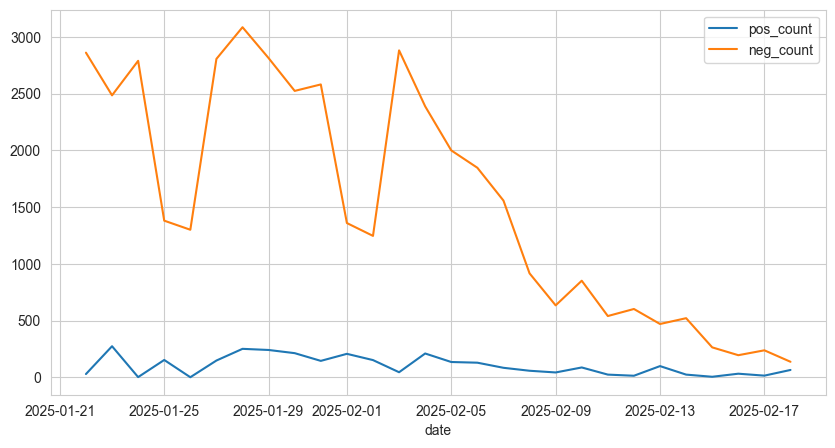

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = counts_sdf.toPandas()
# df.plot(x='date',  kind='hist')

fig, ax = plt.subplots(1, figsize=(10, 10))

df.set_index('date')[['pos_count', 'neg_count']].plot(figsize=(10,5), grid=True, ax=ax)

# ax.set_yticks(range(-10, 41, 5))
# ax.set_yticklabels( ('{}%'.format(x) for x in range(0, 101, 10)), fontsize=15)
# ax.set_xticks(df.date, rotation=45, ha='right')
# ax.set_xticklabels(["{}".format(x) for x in df.date])
ax.legend(loc='upper right')

In [90]:
### DEPRECATED
_objective = "APP_INSTALLS"
# df = _join_obj_roas_sdf.select('date','above_avg','below_avg').where(F.col('objective').isin(_objective)).toPandas()
_obj_sdf=_join_obj_roas_sdf\
                    .filter(F.col('objective').isin(_objective))\
                    .groupBy(F.col('date'))\
                    .agg(F.mean('above_avg').alias('above_avg'),
                         F.mean('below_avg').alias('below_avg'))\
                    .orderBy('date')
_obj_sdf.show()

[Stage 880:=============================================>           (4 + 1) / 5]

+----------+------------------+-------------------+
|      date|         above_avg|          below_avg|
+----------+------------------+-------------------+
|2025-01-22| 9.649200047706396| -9.649200047706394|
|2025-01-23|44.490590237930604| -44.49059023793063|
|2025-01-24| 32.04163919381507| -32.04163919381507|
|2025-01-25| 16.63207673478237| -16.63207673478237|
|2025-01-26|63.380345820761896| -63.38034582076191|
|2025-01-27| 11.31822779949522| -11.31822779949522|
|2025-01-28| 72.83430553941345| -72.83430553941344|
|2025-01-29| 46.17024208403831| -46.17024208403831|
|2025-01-30|11.672596254095014|-11.672596254095014|
|2025-01-31|62.671556754797706|-62.671556754797685|
|2025-02-01|1.2799113067965608|-1.2799113067965608|
|2025-02-02|4.3994116086688795|-4.3994116086688795|
|2025-02-03|1.8499838587105126|-1.8499838587105133|
|2025-02-04|1.2177051984435627| -1.217705198443563|
|2025-02-05|1.0938729703485257|-1.0938729703485262|
|2025-02-06|1.1049338814189598|-1.1049338814189598|
|2025-02-07|

## Filter dataframe by selected columns
__Inputs__
* set the ```_pop_id_col``` variable with an identifier (not necessarilly unique)
* list the ```_filter_by_cols``` with the required set of column names
__outputs__
* ```filt_sdf_``` will produce the filtered dataframe such that none of the rows contain a column with Null value

In [4]:
from pyspark.sql import functions as F

_pop_id_col = 'ad_id'
_filter_by_cols = ['ad_id', 'd1_click', 'd7_click', 'd28_click', 'd1_view', 'd7_view', 'd28_view', 
                   'action_type', 'value']
filt_sdf_ = sdf.select(_filter_by_cols).dropna()
print("Total filtered rows %d for %d unique %s values" 
      % (filt_sdf_.count(), filt_sdf_.select(F.col(_pop_id_col)).distinct().count(), _pop_id_col.upper()))
filt_sdf_.show(n=5, truncate=False)

[Stage 9:>                                                          (0 + 1) / 1]

Total filtered rows 172689 for 4906 unique AD_ID values


[Stage 15:>                                                         (0 + 1) / 1]

+-------------+--------+--------+---------+-------+-------+--------+-----------------------------------------+------+
|ad_id        |d1_click|d7_click|d28_click|d1_view|d7_view|d28_view|action_type                              |value |
+-------------+--------+--------+---------+-------+-------+--------+-----------------------------------------+------+
|6216259122941|69.46   |305.04  |305.04   |160.31 |285.95 |490.8   |offsite_conversion.fb_pixel_add_to_cart  |465.35|
|6216259122941|115.33  |168.53  |168.53   |54.52  |273.93 |273.93  |offsite_conversion.fb_pixel_purchase     |223.05|
|6216259122941|0.0     |10.45   |10.45    |0.0    |0.0    |0.0     |offsite_conversion.fb_pixel_custom       |10.45 |
|6216259122941|17.0    |55.5    |55.5     |847.77 |1975.11|2084.1  |add_to_cart                              |903.27|
|6216259122941|0.0     |0.0     |0.0      |6.16   |6.16   |6.16    |offsite_conversion.custom.814730377326332|6.16  |
+-------------+--------+--------+---------+-------+-----

## Randomly sample the data
[Calculating your sample size](https://www.remesh.ai/resources/how-to-calculate-sample-size)
#### Confidence interval
* First we set the deisred _confidence level_:
  * also cointed as margin of error; typically set at 5%
  * will result in a 95% confindece interval (can also use 90% and 99%)
  * hence, we set ```alpha=0.95```
* _Tolerance_ interval: 90% (0.90 percentile) ensures that p% of the sample
* _Prediction_ interval
* Define the _Population_ by ramdomly selecting N representative rows

In [5]:
from pyspark.sql import functions as F

def confidence_interval(df, grp):
    # col = F.when(F.col('status') == F.lit('ACTIVE'), 1.0).otherwise(0.0)
    col_ = 'd1_click'

    return df.groupBy(grp).agg(
        F.mean(col_).alias('mean'),
        F.count(F.col(col_)).alias('total'),
        F.stddev(col_).alias('std')
    ).withColumn(
        'ci95_hi',
        F.col('mean') + 1.96 * F.col('std') / F.sqrt(F.col('total'))
    ).withColumn(
        'ci95_lo',
        F.col('mean') - 1.96 * F.col('std') / F.sqrt(F.col('total'))
    )

confidence_interval(filt_sdf_, 'action_type').show(truncate=False)

[Stage 16:>                                                         (0 + 1) / 1]

+---------------------------------------------+------------------+-----+------------------+------------------+------------------+
|action_type                                  |mean              |total|std               |ci95_hi           |ci95_lo           |
+---------------------------------------------+------------------+-----+------------------+------------------+------------------+
|offsite_conversion.fb_pixel_search           |640.7014705882353 |340  |870.6589685522944 |733.2489704276998 |548.1539707487709 |
|offsite_conversion.custom.814730377326332    |0.7744172086043025|1999 |2.5929290250512023|0.8880857542863496|0.6607486629222554|
|offsite_conversion.custom.6508804492500376   |36.32727272727273 |55   |34.51197030417264 |45.44831525517694 |27.206230199368523|
|offsite_conversion.fb_pixel_purchase         |135.0893611937763 |69896|8289.946985837309 |196.54781971682343|73.6309026707292  |
|offsite_conversion.fb_pixel_custom           |23.921662269129286|379  |60.276364137898845

In [5]:
column_index_1 = 'd28_click'
column_index_2 = 'd28_view'

fraction = 0.4
''' Apply transformation on every element by defining the columns (first, second) 
    as well as sampling percentage as an argument in the map function '''
fractions = filt_sdf_.rdd.map(lambda x:
                              (x[column_index_1],
                               x[column_index_2]))\
                    .distinct()\
                    .map(lambda x:
                         (x,fraction)).collectAsMap()
print("created franctions for %d index pairs" % len(fractions))
# Create tuple of elements using keyBy function 
key_df = filt_sdf_.rdd.keyBy(lambda x: (x[column_index_1],x[column_index_2]))

# Extract random sample through sampleByKey function 
# using boolean, columns (first and second) and fraction as arguments 
print("Sample 1: ")
sample_1_sdf = key_df.sampleByKey(
    False, fractions).map(lambda x: x[1]).toDF(filt_sdf_.columns)
sample_1_sdf.show(n=5, truncate=False)
 
# Again extract random sample through sampleByKey function 
# using boolean, columns (first and second) and fraction as arguments 
print("Sample 2: ")
sample_2_sdf = key_df.sampleByKey(
    False, fractions).map(lambda x: x[1]).toDF(filt_sdf_.columns)
sample_2_sdf.show(n=5, truncate=False)

created franctions for 73070 index pairs
Sample 1: 


+-------------+--------+--------+---------+-------+-------+--------+-----------------------------------------+------+
|ad_id        |d1_click|d7_click|d28_click|d1_view|d7_view|d28_view|action_type                              |value |
+-------------+--------+--------+---------+-------+-------+--------+-----------------------------------------+------+
|6216259122941|69.46   |305.04  |305.04   |160.31 |285.95 |490.8   |offsite_conversion.fb_pixel_add_to_cart  |465.35|
|6216259122941|115.33  |168.53  |168.53   |54.52  |273.93 |273.93  |offsite_conversion.fb_pixel_purchase     |223.05|
|6216259122941|0.0     |0.0     |0.0      |6.16   |6.16   |6.16    |offsite_conversion.custom.814730377326332|6.16  |
|6216259122941|150.8   |150.8   |150.8    |317.55 |530.58 |530.58  |offsite_conversion.fb_pixel_purchase     |468.35|
|6216259324541|85.73   |290.66  |290.66   |395.09 |486.82 |505.65  |offsite_conversion.fb_pixel_purchase     |685.75|
+-------------+--------+--------+---------+-------+-----

[Stage 21:>                                                         (0 + 1) / 1]

+-------------+--------+--------+---------+-------+-------+--------+-----------------------------------------+------+
|ad_id        |d1_click|d7_click|d28_click|d1_view|d7_view|d28_view|action_type                              |value |
+-------------+--------+--------+---------+-------+-------+--------+-----------------------------------------+------+
|6216259122941|69.46   |305.04  |305.04   |160.31 |285.95 |490.8   |offsite_conversion.fb_pixel_add_to_cart  |465.35|
|6216259122941|115.33  |168.53  |168.53   |54.52  |273.93 |273.93  |offsite_conversion.fb_pixel_purchase     |223.05|
|6216259122941|17.0    |55.5    |55.5     |847.77 |1975.11|2084.1  |add_to_cart                              |903.27|
|6216259122941|0.0     |0.0     |0.0      |6.16   |6.16   |6.16    |offsite_conversion.custom.814730377326332|6.16  |
|6216259122941|26.24   |91.7    |91.7     |634.78 |697.34 |697.34  |offsite_conversion.fb_pixel_purchase     |726.48|
+-------------+--------+--------+---------+-------+-----

## Chi-square test

#### Apply OneHotEncoding
Convert categorical strings to numerical values

In [6]:
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.stat import ChiSquareTest

''' define sample data '''
sample_sdf = sample_1_sdf .drop(F.col('ad_id'))

''' StringIndexer Initialization '''
_label_col = 'action_type'
indexer = StringIndexer(inputCol=_label_col, outputCol="Categories_Indexed")
indexerModel = indexer.fit(sample_sdf)

# Transform the DataFrame using the fitted StringIndexer model
indexed_df = indexerModel.transform(sample_sdf)
# indexed_df.show()
''' apply encoder '''
encoder = OneHotEncoder(inputCol="Categories_Indexed", outputCol="labels")
encoded_df = encoder.fit(indexed_df).transform(indexed_df)
encoded_df.select(_label_col, "Categories_Indexed", "labels").show(n=5, truncate=False)

[Stage 25:>                                                         (0 + 1) / 1]

+-----------------------------------------+------------------+--------------+
|action_type                              |Categories_Indexed|labels        |
+-----------------------------------------+------------------+--------------+
|offsite_conversion.fb_pixel_add_to_cart  |1.0               |(16,[1],[1.0])|
|offsite_conversion.fb_pixel_purchase     |0.0               |(16,[0],[1.0])|
|offsite_conversion.custom.814730377326332|6.0               |(16,[6],[1.0])|
|offsite_conversion.fb_pixel_purchase     |0.0               |(16,[0],[1.0])|
|offsite_conversion.fb_pixel_purchase     |0.0               |(16,[0],[1.0])|
+-----------------------------------------+------------------+--------------+
only showing top 5 rows



In [7]:
_remove_lst = ['action_type', 'labels']
_feature_cols = [x for x in encoded_df.columns if x not in _remove_lst]
# _features='d28_click'

assembler = VectorAssembler(inputCols = _feature_cols, outputCol = 'features')
vec_sdf = assembler.transform(encoded_df)
vec_sdf.show(n=5, truncate=False)


[Stage 26:>                                                         (0 + 1) / 1]

+--------+--------+---------+-------+-------+--------+-----------------------------------------+------+------------------+--------------+-----------------------------------------------------+
|d1_click|d7_click|d28_click|d1_view|d7_view|d28_view|action_type                              |value |Categories_Indexed|labels        |features                                             |
+--------+--------+---------+-------+-------+--------+-----------------------------------------+------+------------------+--------------+-----------------------------------------------------+
|69.46   |305.04  |305.04   |160.31 |285.95 |490.8   |offsite_conversion.fb_pixel_add_to_cart  |465.35|1.0               |(16,[1],[1.0])|[69.46,305.04,305.04,160.31,285.95,490.8,465.35,1.0] |
|115.33  |168.53  |168.53   |54.52  |273.93 |273.93  |offsite_conversion.fb_pixel_purchase     |223.05|0.0               |(16,[0],[1.0])|[115.33,168.53,168.53,54.52,273.93,273.93,223.05,0.0]|
|0.0     |0.0     |0.0      |6.16   |6.1

In [26]:
r = ChiSquareTest.test(vec_sdf.select('features', 'Categories_Indexed').limit(100), 'features', 'Categories_Indexed')

## Results
the chi-square test result helps you determine if differences in feature values are due to chance or if they reflect a true pattern. It is used to test and compare two different types of data: observed data and expected data; thus, measures what is called the "goodness to fit" which is the difference between what you'd expect and what has been observed

The hypothese we are testing is to determine if the features: ```d1_click, d7_click, d28_click, d1_view, d7_view, d28_view, value``` have an effect (or are associated) with ```action_type```; which may describe how budgets might be distributed???)

w.r.t Chi-square test:
*  _P-Value_ is a statistical measure that helps to assess the importance of your test results
*  _ndegreesOfFreedom_ is the number of cells in the deature sample that can vary before the rest can be calculated
*  _statistic_ compares the size of any discrepancies between the expected results and the actual results, given the size of the sample and the number of variables in the relationship

In [41]:
vals = r.first()
print("Sample size: 1000")
print("\nfeatures: d1_click, d7_click, d28_click, d1_view, d7_view, d28_view, value")
print("label: action_type")
print("\npValues: " + str(vals[0]))
# print("\ndegreesOfFreedom: " + str(vals[1]))
# print("\nstatistics: " + str(vals[2]))

Sample size: 1000

features: d1_click, d7_click, d28_click, d1_view, d7_view, d28_view, value
label: action_type

pValues: [0.048493226111149035,0.44627209161354975,0.6508140984033642,0.6624499875134036,0.46458059439628785,0.625566214596088,0.31327071857175204,0.0]


## DEPRECATED

In [21]:
import pandas as pd
from scipy.stats import chi2_contingency
from pyspark.mllib.stat import Statistics as stat

sample_sdf = vec_sdf

col_1 = 'd28_click'
col_2 = 'Categories_Indexed'

chisqr_sdf = sample_sdf.select(col_1,col_2)\
                .where((F.col(col_1).isNotNull()) & (F.col(col_1)==0))\
                .where((F.col(col_2).isNotNull()) & (F.col(col_2)==0))

contingency_table = chisqr_sdf.stat.crosstab(col_1, col_2)
contingency_table.show(truncate=False)

#Converting spark contingency_table to pandas DataFrame
contingency_table_df = contingency_table.toPandas()
contingency_table_df = contingency_table_df.set_index(col_1+"_"+col_2)
# Perform the chi-square test
chi2, p_value, degrees_of_freedom, expected_frequencies = chi2_contingency(contingency_table_df)

# Print the results
print("Chi-Square Statistic:", chi2)
print("P-Value:", p_value)
print("Degrees of Freedom:", degrees_of_freedom)

print(" ")
print("Contingency Table:")
print(contingency_table_df)

print(" ")
print("Expected Frequencies:")
print(pd.DataFrame(expected_frequencies, index=contingency_table_df.index, columns=contingency_table_df.columns))

+----------------------------+-----+
|d28_click_Categories_Indexed|0.0  |
+----------------------------+-----+
|0.0                         |12353|
+----------------------------+-----+



[Stage 47:>                                                         (0 + 1) / 1]

Chi-Square Statistic: 0.0
P-Value: 1.0
Degrees of Freedom: 0
 
Contingency Table:
                                0.0
d28_click_Categories_Indexed       
0.0                           12353
 
Expected Frequencies:
                                  0.0
d28_click_Categories_Indexed         
0.0                           12353.0


In [ ]:
sample_sdf = sdf.select(_filter_by_cols)\
                .where(F.col('click_d28').isNotNull())\
                .orderBy(F.rand()).limit(100)
print("randomly selected %d rows" % sample_sdf.count())
sample_sdf.show(n=3)

randomly selected 100 rows


[Stage 56:>                                                         (0 + 1) / 1]

+---------+------+
|d28_click| value|
+---------+------+
|     45.0|  45.0|
|      0.0|215.49|
|   345.23|456.38|
+---------+------+
only showing top 3 rows

